Loaded tweets: 300 rows
Loaded reviews: 200 rows
Loaded news: 250 rows
Topic modeling completed for tweets
Topic modeling completed for reviews
Topic modeling completed for news


C:\Users\Abhishekgantana\AppData\Local\Temp\ipykernel_21172\3547029756.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="dominant_topic", y="sentiment_score", data=topic_sentiment, palette="coolwarm")


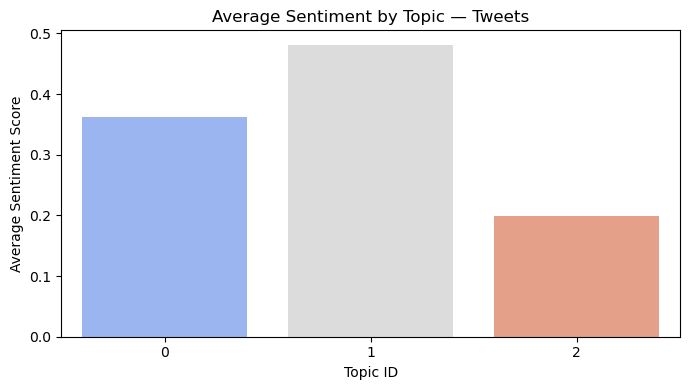

Saved tweets_sentiment_by_topic.png


C:\Users\Abhishekgantana\AppData\Local\Temp\ipykernel_21172\3547029756.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="dominant_topic", y="sentiment_score", data=topic_sentiment, palette="coolwarm")


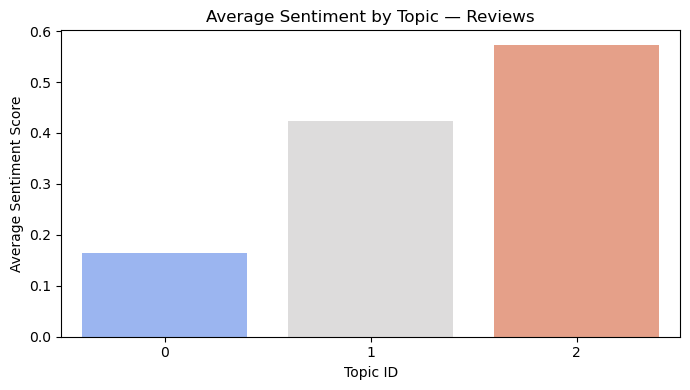

Saved reviews_sentiment_by_topic.png


C:\Users\Abhishekgantana\AppData\Local\Temp\ipykernel_21172\3547029756.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="dominant_topic", y="sentiment_score", data=topic_sentiment, palette="coolwarm")


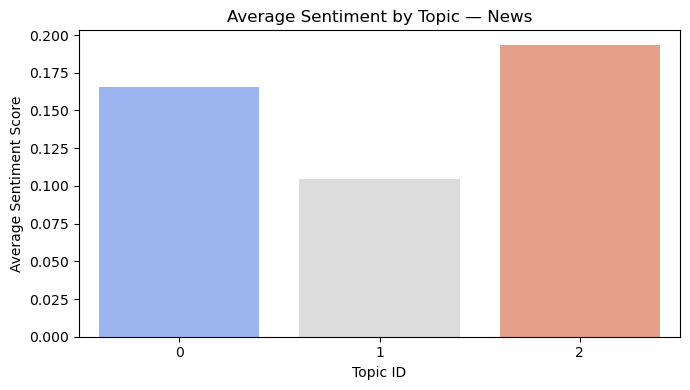

Saved news_sentiment_by_topic.png

Sentiment Summary Across Platforms:
                  tweets   reviews      news
Mean Sentiment  0.361916  0.337006  0.150010
Std Deviation   0.389130  0.279495  0.124059


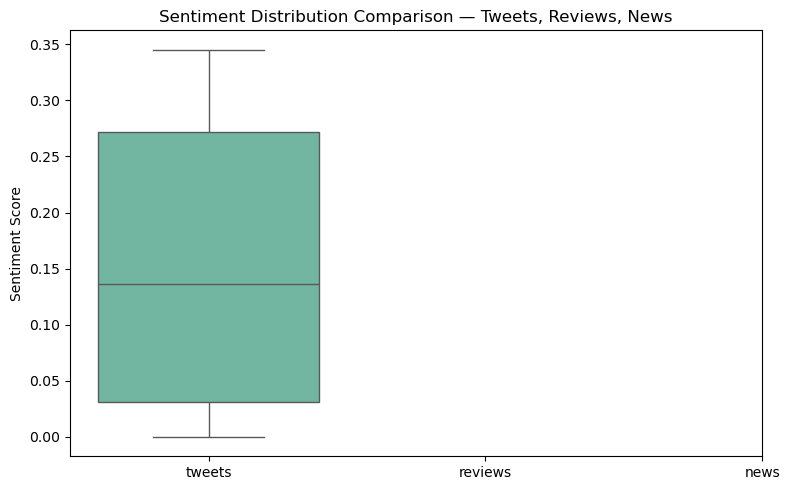

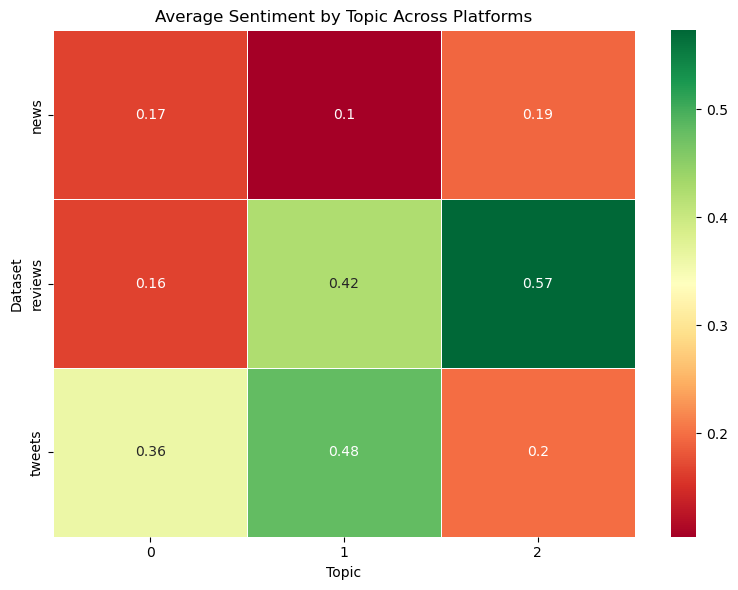


Summary of Insights:
   Dataset  Average Sentiment  Most Positive Topic
0   tweets              0.362                    1
1  reviews              0.337                    2
2     news              0.150                    2

Notebook 4 complete — All charts and tables saved in /outputs/


In [1]:
# ============================================================
# NOTEBOOK 4 — Sentiment & Topic Correlation Analysis
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ---------- Setup ----------
input_folder = "./outputs/"
output_folder = "./outputs/"
os.makedirs(output_folder, exist_ok=True)

# ---------- Load Data ----------
files = {
    "tweets": "tweets_with_sentiment.csv",
    "reviews": "reviews_with_sentiment.csv",
    "news": "news_with_sentiment.csv",
}

datasets = {}
for name, file in files.items():
    path = os.path.join(input_folder, file)
    if os.path.exists(path):
        datasets[name] = pd.read_csv(path)
        print(f"Loaded {name}: {datasets[name].shape[0]} rows")
    else:
        print(f"Warning: {file} not found.")

# ============================================================
# Step 1: Topic Modeling (Lightweight Version)
# ============================================================

tfidf = TfidfVectorizer(max_features=500, stop_words="english")

topic_data = {}
for name, df in datasets.items():
    if "cleaned_text" not in df.columns:
        continue
    tfidf_matrix = tfidf.fit_transform(df["cleaned_text"].dropna())
    lda = LatentDirichletAllocation(n_components=3, random_state=42)
    topic_weights = lda.fit_transform(tfidf_matrix)
    df["dominant_topic"] = topic_weights.argmax(axis=1)
    datasets[name] = df
    topic_data[name] = df
    print(f"Topic modeling completed for {name}")

# ============================================================
# Step 2: Sentiment vs Topic Correlation
# ============================================================

for name, df in datasets.items():
    topic_sentiment = df.groupby("dominant_topic")["sentiment_score"].mean().reset_index()
    plt.figure(figsize=(7,4))
    sns.barplot(x="dominant_topic", y="sentiment_score", data=topic_sentiment, palette="coolwarm")
    plt.title(f"Average Sentiment by Topic — {name.capitalize()}")
    plt.xlabel("Topic ID")
    plt.ylabel("Average Sentiment Score")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{name}_sentiment_by_topic.png"))
    plt.show()
    print(f"Saved {name}_sentiment_by_topic.png")

# ============================================================
# Step 3: Sentiment Distribution per Platform
# ============================================================

sentiment_stats = pd.DataFrame({
    name: [df["sentiment_score"].mean(), df["sentiment_score"].std()]
    for name, df in datasets.items()
}, index=["Mean Sentiment", "Std Deviation"])

print("\nSentiment Summary Across Platforms:")
print(sentiment_stats)

plt.figure(figsize=(8,5))
sns.boxplot(data=[df["sentiment_score"] for df in datasets.values()], palette="Set2")
plt.xticks(range(len(datasets)), list(datasets.keys()))
plt.title("Sentiment Distribution Comparison — Tweets, Reviews, News")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "sentiment_distribution_comparison.png"))
plt.show()

# ============================================================
# Step 4: Correlation Heatmap (Sentiment vs Topic Frequency)
# ============================================================

topic_summary = []
for name, df in datasets.items():
    counts = df["dominant_topic"].value_counts(normalize=True).sort_index()
    avg_sentiment = df.groupby("dominant_topic")["sentiment_score"].mean()
    correlation = pd.DataFrame({
        "Topic": counts.index,
        "Frequency": counts.values,
        "Avg Sentiment": avg_sentiment.values,
        "Dataset": name
    })
    topic_summary.append(correlation)

summary_df = pd.concat(topic_summary, ignore_index=True)

plt.figure(figsize=(8,6))
pivot = summary_df.pivot_table(index="Dataset", columns="Topic", values="Avg Sentiment")
sns.heatmap(pivot, annot=True, cmap="RdYlGn", linewidths=0.5)
plt.title("Average Sentiment by Topic Across Platforms")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "sentiment_topic_heatmap.png"))
plt.show()

# ============================================================
# Step 5: Key Insights
# ============================================================

insights = []
for name, df in datasets.items():
    avg_sentiment = df["sentiment_score"].mean()
    top_topic = df.groupby("dominant_topic")["sentiment_score"].mean().idxmax()
    insights.append({
        "Dataset": name,
        "Average Sentiment": round(avg_sentiment, 3),
        "Most Positive Topic": int(top_topic)
    })

insight_df = pd.DataFrame(insights)
insight_df.to_csv(os.path.join(output_folder, "sentiment_topic_insights.csv"), index=False)

print("\nSummary of Insights:")
print(insight_df)
print("\nNotebook 4 complete — All charts and tables saved in /outputs/")
